# Fitting MFT $J_{ij}$

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
autoreload 2

In [166]:
from clean_data import voting_data, C, pvec, pbin, J_diag_factor, V, Vinv, cvals, N, justices

In [164]:
import pandas as pd
import numpy as np
import fast
from math import sqrt
import scipy as sp
import scipy.linalg as la

In [182]:
def get_analytic_J(gamma):
    """ Returns the analytic solution for Jij given a gamma tuning term """
    jvals = [np.power(0.5 * (cq - gamma + sqrt((cq - gamma)**2 + 4 * gamma)), -1) for cq in cvals]
    J_prime = V@np.diag(jvals)@Vinv
    J = np.zeros((9,9))

    factor = 0
    for i in range(N):
        for j in range(N):
            factor = sqrt(pvec[i] * (1-pvec[i]) * pvec[j] * (1-pvec[j]))
            J[i][j] = J_prime[i][j] / factor
            J[j][i] = J_prime[j][i] / factor


    for i in range(N):
        J[i][i] = 0.0
    return(J)

def ising_log_likelihood(state, J):
    return(-state@J@state)

def mft_log_likelihood(J, gamma):
    mft_term = 0.0
    for i in range(N):
        for j in range(i+1, N):
            mft_term += (J[i][j] * J[i][j]) * pvec[i] * (1-pvec[i]) * pvec[j] * (1-pvec[j])
    return(gamma * mft_term)

def my_chi_squared(gamma):
    J = get_analytic_J(gamma)
    start_state = np.random.choice([-1,1], size = N)
    
    #J = np.loadtxt("jij_sols.csv", delimiter=",")
    probs, all_states = fast.my_test_sample(gamma, start_state, J, 
                        num_samples = 16000)
    

    num_data_pts = 810

    chi = 0.0
    all_states_transpose = np.transpose((all_states + 1.0) / 2.0)
    for i in range(N):
        for j in range(i, N):
            err = pbin[i][j] * (1-pbin[i][j]) / num_data_pts
            pij_model = np.sum(all_states_transpose[i] * all_states_transpose[j] * probs)
            chi += (2 / (9 * 10)) * ((pbin[i][j] - pij_model) ** 2) / err
    return(chi)

In [32]:
J_correct = np.loadtxt("jij_sols.csv", delimiter=',')

In [21]:
def plot_heatmap(J):
   # J_ = deepcopy(J)
    J_ = J
    if J_.shape != (9,9): J_ = J_.reshape((9,9))
    cm = sns.diverging_palette(248, 12, sep=1, n=256)
    sns.heatmap(J_, cmap=cm, xticklabels=justices, yticklabels=justices,  vmin=-1, vmax=1)

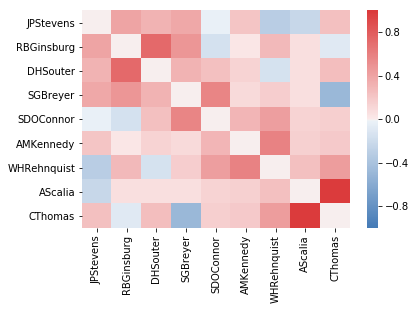

In [33]:
plot_heatmap(J_correct)

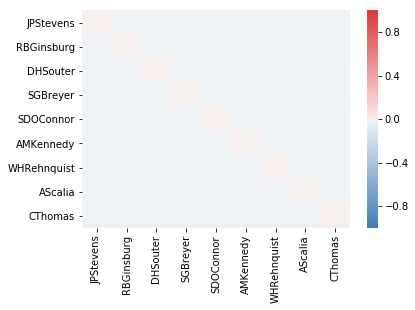

In [186]:
plot_heatmap(get_analytic_J(1273560.4226874656))

In [184]:
def myf(gamma):
    J = get_analytic_J(gamma)
    A = J - J_correct
    return(np.sum(A.reshape((81)))**2)
    

In [185]:
minimize_scalar(myf)

     fun: 211.39742427519735
    nfev: 81
     nit: 24
 success: True
       x: 1273560.4226874656

In [7]:
# IT DOESN'T MATTER NOW, BUT MAKE SURE THAT YOU UPDATE WITH THE REGULARIZATION TERM

0